In [1]:
import json
import time
from typing import Dict

from datasets import load_dataset, load_from_disk# type: ignore
from datasets.formatting.formatting import LazyBatch # type: ignore
from huggingface_hub import list_datasets # type: ignore
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
import statsmodels as sm

/Users/nasimeh/anaconda3/envs/npss/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
dataset_dict2 = load_from_disk('Merged_Close_feature_sp_date')

In [3]:
df_train=pd.DataFrame(dataset_dict2['train'])
df_val=pd.DataFrame(dataset_dict2['validation'])
df_test=pd.DataFrame(dataset_dict2['test'])

In [4]:
df_train['Close_numeric']=np.nan
df_test['Close_numeric']=np.nan
df_val['Close_numeric']=np.nan
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


In [5]:
for i in range(0, len(df_train)):
    if df_train['Close'][i] != None:
        df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))

for i in range(0, len(df_test)):
    if df_test['Close'][i] != None:
        df_test['Close_numeric'][i] = float(df_test['Close'][i].replace(',', ''))
    
for i in range(0, len(df_val)):
    if df_val['Close'][i] != None:
        df_val['Close_numeric'][i] = float(df_val['Close'][i].replace(',', ''))

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/2016532180.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))
/var/folders/g7/0r52jtgn0lx64hw0zmgwg

In [6]:
type(df_train['Close'][1])

str

In [7]:
df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
df_test['Close_numeric'].interpolate(method='nearest', inplace=True)
df_val['Close_numeric'].interpolate(method='nearest', inplace=True)
df_train['Close_numeric'].fillna(method='ffill', inplace=True)
df_test['Close_numeric'].fillna(method='ffill', inplace=True)
df_val['Close_numeric'].fillna(method='ffill', inplace=True)
df_train['Close_numeric'].fillna(method='bfill', inplace=True)
df_test['Close_numeric'].fillna(method='bfill', inplace=True)
df_val['Close_numeric'].fillna(method='bfill', inplace=True)
# Other methods: 'polynomial', 'spline', 'quadratic'
#df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2
# df_train['Close_numeric'][0]=df_train['Close_numeric'][1]

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/3699060469.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/3699060469.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [8]:
df_train['Close_numeric']

0      3824.14
1      3824.14
2      3852.97
3      3808.10
4      3895.08
        ...   
217    4186.77
218    4137.23
219    4117.37
220    4166.82
221    4193.80
Name: Close_numeric, Length: 222, dtype: float64

In [9]:
df_test['Diff']=df_test.Close_numeric.diff()
df_test['Diff'][0]=0

df_train['Diff']=df_train.Close_numeric.diff()
df_train['Diff'][0]=0

df_val['Diff']=df_val.Close_numeric.diff()
df_val['Diff'][0]=0

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/3202477990.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test['Diff'][0]=0
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/3202477990.py:2: SettingWit

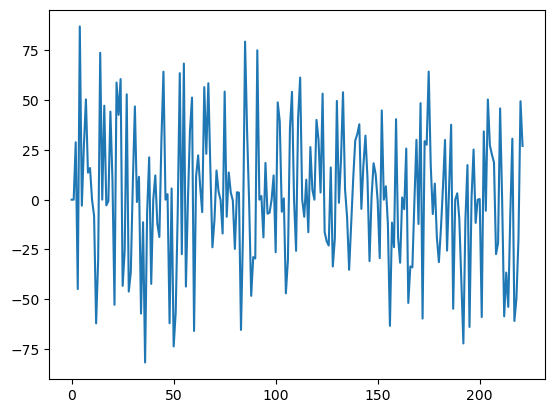

In [10]:
plt.plot(df_train['Diff'])

In [11]:
df_train['Diff'].std()

34.185376815104874

In [12]:
dataset_dict_t= load_from_disk('NYdatasp_SP_datset')

In [13]:
df_train_t=pd.DataFrame(dataset_dict_t['train'])
df_val_t=pd.DataFrame(dataset_dict_t['validation'])
df_test_t=pd.DataFrame(dataset_dict_t['test'])

In [14]:
df_train_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   abstract          222 non-null    object             
 1   web_url           143 non-null    object             
 2   snippet           143 non-null    object             
 3   lead_paragraph    143 non-null    object             
 4   print_section     82 non-null     object             
 5   print_page        82 non-null     object             
 6   source            143 non-null    object             
 7   multimedia        143 non-null    object             
 8   headline          143 non-null    object             
 9   keywords          143 non-null    object             
 10  pub_date          143 non-null    datetime64[ns, UTC]
 11  document_type     143 non-null    object             
 12  news_desk         143 non-null    object             
 13  secti

In [15]:
df_train_t['Close_numeric']=np.nan
df_test_t['Close_numeric']=np.nan
df_val_t['Close_numeric']=np.nan
df_train_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   abstract          222 non-null    object             
 1   web_url           143 non-null    object             
 2   snippet           143 non-null    object             
 3   lead_paragraph    143 non-null    object             
 4   print_section     82 non-null     object             
 5   print_page        82 non-null     object             
 6   source            143 non-null    object             
 7   multimedia        143 non-null    object             
 8   headline          143 non-null    object             
 9   keywords          143 non-null    object             
 10  pub_date          143 non-null    datetime64[ns, UTC]
 11  document_type     143 non-null    object             
 12  news_desk         143 non-null    object             
 13  secti

In [16]:
for i in range(0, len(df_train_t)):
    if df_train_t['Close'][i] != None:
        df_train_t['Close_numeric'][i] = float(df_train_t['Close'][i].replace(',', ''))

for i in range(0, len(df_test_t)):
    if df_test_t['Close'][i] != None:
        df_test_t['Close_numeric'][i] = float(df_test_t['Close'][i].replace(',', ''))
    
for i in range(0, len(df_val_t)):
    if df_val_t['Close'][i] != None:
        df_val_t['Close_numeric'][i] = float(df_val_t['Close'][i].replace(',', ''))

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/3211204799.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train_t['Close_numeric'][i] = float(df_train_t['Close'][i].replace(',', ''))
/var/folders/g7/0r52jtgn0lx64hw0z

In [17]:
df_train_t['Close_numeric'].interpolate(method='nearest', inplace=True)
df_test_t['Close_numeric'].interpolate(method='nearest', inplace=True)
df_val_t['Close_numeric'].interpolate(method='nearest', inplace=True)
df_train_t['Close_numeric'].fillna(method='ffill', inplace=True)
df_test_t['Close_numeric'].fillna(method='ffill', inplace=True)
df_val_t['Close_numeric'].fillna(method='ffill', inplace=True)
df_train_t['Close_numeric'].fillna(method='bfill', inplace=True)
df_test_t['Close_numeric'].fillna(method='bfill', inplace=True)
df_val_t['Close_numeric'].fillna(method='bfill', inplace=True)

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/506361694.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_t['Close_numeric'].interpolate(method='nearest', inplace=True)
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/506361694.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [18]:
df_test_t['Diff']=df_test_t.Close_numeric.diff()
df_test_t['Diff'][0]=0

df_train_t['Diff']=df_train_t.Close_numeric.diff()
df_train_t['Diff'][0]=0

df_val_t['Diff']=df_val_t.Close_numeric.diff()
df_val_t['Diff'][0]=0

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/2280410736.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test_t['Diff'][0]=0
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_59062/2280410736.py:2: SettingW

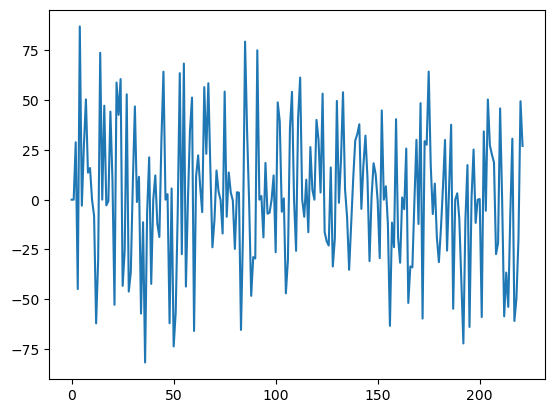

In [19]:
plt.plot(df_train_t['Diff'])

In [20]:
df_train_t['Diff']

0       0.00
1       0.00
2      28.83
3     -44.87
4      86.98
       ...  
217   -60.91
218   -49.54
219   -19.86
220    49.45
221    26.98
Name: Diff, Length: 222, dtype: float64

In [21]:
df_train_t['abstract'][5]

'Analysts have begun trimming their profit forecasts, with pronounced downgrades for growth at energy and financial firms.'

In [22]:
df_train_t['Diff'][5]

-2.9899999999997817

In [23]:
from transformers import pipeline

# Load the sentiment-analysis pipeline
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')


def get_sentiment_label_and_score(text):
    result = classifier(text)
    return result[0]['label'], result[0]['score']

# Apply the classifier to each abstract and create new columns for the sentiment and score
df_val_t[['sentiment', 'sentiment_score']] = df_val_t['abstract'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

df_train_t[['sentiment', 'sentiment_score']] = df_train_t['abstract'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

# Apply the classifier to each abstract and create new columns for the sentiment and score
df_test_t[['sentiment', 'sentiment_score']] = df_test_t['abstract'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

In [24]:
df_val_t[['sentiment', 'sentiment_score']]

,sentiment,sentiment_score
0,POSITIVE,0.977451
1,NEGATIVE,0.984116
2,POSITIVE,0.967290
3,POSITIVE,0.748121
4,NEGATIVE,0.986423
5,POSITIVE,0.748121
6,POSITIVE,0.748121
7,NEGATIVE,0.874683
8,POSITIVE,0.748121
9,NEGATIVE,0.994755


In [29]:
get_sentiment_label_and_score(df_val_t.abstract.iloc[1])

('NEGATIVE', 0.9841164946556091)

In [42]:
def get_drift(text):
    result = (text['sentiment']=='POSITIVE')*text['sentiment_score']-(text['sentiment']=='NEGATIVE')*text['sentiment_score']
    return result

df_val_t['drift']=df_val_t[['sentiment', 'sentiment_score']].apply(lambda x: get_drift(x), axis=1)

df_train_t['drift']=df_train_t[['sentiment', 'sentiment_score']].apply(lambda x: get_drift(x), axis=1)

df_test_t['drift']=df_test_t[['sentiment', 'sentiment_score']].apply(lambda x: get_drift(x), axis=1)

In [31]:
def get_main(x):
    if not isinstance(x, dict):
        return ''
    res=x.get('main')
    return res

'Why Wall Street Is So Worried About ‘Refunding’'

In [38]:
df_val_t['head_main']=df_val_t.headline.apply(get_main)
df_train_t['head_main']=df_train_t.headline.apply(get_main)
df_test_t['head_main']=df_test_t.headline.apply(get_main)

In [39]:
# Apply the classifier to each abstract and create new columns for the sentiment and score
df_val_t[['head sentiment', 'head sentiment_score']] = df_val_t['head_main'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

df_train_t[['head sentiment', 'head sentiment_score']] = df_train_t['head_main'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

df_test_t[['head sentiment', 'head sentiment_score']] = df_test_t['head_main'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

In [41]:
def get_drift_head(text):
    result = (text['head sentiment']=='POSITIVE')*text['head sentiment_score']-(text['head sentiment']=='NEGATIVE')*text['head sentiment_score']
    return result

df_val_t['drift_head']=df_val_t[['head sentiment', 'head sentiment_score']].apply(lambda x: get_drift_head(x), axis=1)

df_train_t['drift_head']=df_train_t[['head sentiment', 'head sentiment_score']].apply(lambda x: get_drift_head(x), axis=1)

df_test_t['drift_head']=df_test_t[['head sentiment', 'head sentiment_score']].apply(lambda x: get_drift_head(x), axis=1)

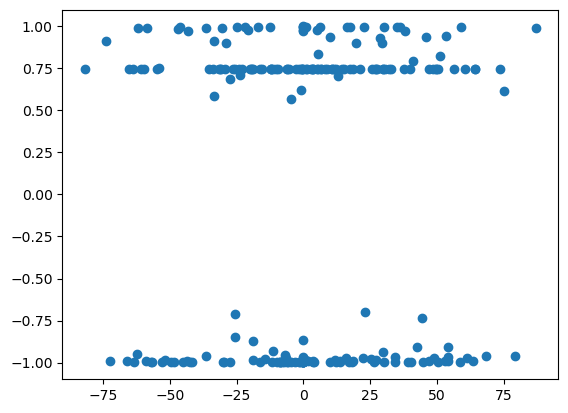

In [47]:
plt.scatter(df_train_t['Diff'], df_train_t['drift_head'])

In [48]:
np.corrcoef(df_train_t['drift'], df_train_t['drift_head'])

array([[1.       , 0.4674484],
       [0.4674484, 1.       ]])

News-based random walk with Drift model:

$$y_0=\beta_0, \ \ y_t=y_{t-1}+\beta_1*d_t+\epsilon_t$$

where $d_t$ is the drift score calculated based on the news sentiment. 

$$
\begin{align*}
\hat{\beta}_1 &= \frac{1}{n}\sum_{i=1}^n \frac{(y_i - y_{i-1})}{d_i} \\
\hat{\beta}_0 &= y_0\\
\hat{\sigma}^2 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1} - \hat{\beta}_1*d_i)^2
\end{align*}
$$

In [ ]:
beta1=np.sum(df_train_t['Diff'][1:] / df_train_t['drift'][:-1])/(len(df_train_t)-1)
beta1

In [ ]:
plt.scatter(df_train_t.Diff.values[1:], df_train_t.drift.values[:-1].cumsum())

In [ ]:
correlation=[]
for i in range(1, len(df_train_t)):
    correlation.append(np.corrcoef(df_train_t['Diff'][i:], df_train_t['drift'][:-i].cumsum())[0,1])


In [ ]:
plt.plot(correlation)

In [ ]:
df_train_t[['Diff','drift']]

In [ ]:
df_train_val_t=pd.concat([df_train_t, df_val_t], axis=0)

In [ ]:
def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom


In [ ]:
len(df_train_val_t)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

cv=TimeSeriesSplit(n_splits=len(df_val_t), test_size=1)


Mase_t=np.zeros([len(df_val_t),4])
rmse=np.zeros([len(df_val_t),4])


for i, (train_index,holdout_index) in enumerate(cv.split(df_train_val_t)):
    df_tt=df_train_val_t.iloc[train_index]
    df_ho=df_train_val_t.iloc[holdout_index]
    for lag in range(1,5):
        beta1=np.sum(df_tt['Diff'][lag:]/ df_tt['drift'][:-lag])/len(df_tt['Diff'][lag:])
        drift_pred = df_tt.Close_numeric.iloc[-1] + beta1*df_tt.drift.iloc[-lag]

        Mase_t[i,lag-1]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, drift_pred)
        rmse[i,lag-1]=np.sqrt((df_ho.Close_numeric.values-drift_pred)**2)



In [ ]:
Mase_t.mean(axis=0)

In [ ]:
rmse.mean(axis=0)

In [ ]:
dataset_dict_g= load_from_disk('NYdata_GOOG_datset')

In [ ]:
df_train_g=pd.DataFrame(dataset_dict_g['train'])
df_test_g=pd.DataFrame(dataset_dict_g['test'])

In [ ]:
type(df_train_g.Close[0])

In [ ]:
df_train_g.info()

In [ ]:
df_train_g['Close'].interpolate(method='nearest', inplace=True)
df_test_g['Close'].interpolate(method='nearest', inplace=True)
df_train_g['Close'].fillna(method='ffill', inplace=True)
df_test_g['Close'].fillna(method='ffill', inplace=True)
df_train_g['Close'].fillna(method='bfill', inplace=True)
df_test_g['Close'].fillna(method='bfill', inplace=True)


In [ ]:
df_test_g['Diff']=df_test_g.Close.diff()
df_test_g['Diff'][0]=0

df_train_g['Diff']=df_train_g.Close.diff()
df_train_g['Diff'][0]=0


In [ ]:
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')



# Apply the classifier to each abstract and create new columns for the sentiment and score
df_test_g[['sentiment', 'sentiment_score']] = df_test_g['abstract'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)

df_train_g[['sentiment', 'sentiment_score']] = df_train_g['abstract'].apply(
    lambda x: pd.Series(get_sentiment_label_and_score(x))
)



In [ ]:
df_test_g.headline.iloc[1]['main']

In [ ]:
get_sentiment_label_and_score(df_test_g.headline.iloc[1]['main'])


In [ ]:
df_test_g.sentiment.iloc[1]

In [ ]:

df_train_g['drift']=df_train_g[['sentiment', 'sentiment_score']].apply(lambda x: get_drift(x), axis=1)

df_test_g['drift']=df_test_g[['sentiment', 'sentiment_score']].apply(lambda x: get_drift(x), axis=1)

In [ ]:
plt.scatter(df_train_g.Diff.values[1:], df_train_g.drift.values[:-1].cumsum())